In [101]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
q='''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id, ifnull(count(distinct sha),0) as commit_count
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    join release_type rt on rt.release_info_id = ri.id
    left join change_commit cc on ri.id = cc.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    -- and rt.type = 'patch'
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
cc = pd.DataFrame(sql.execute(q)) 

In [103]:
q= '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id,
       ifnull(count(distinct filename),0) as file_count
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    join release_type rt on rt.release_info_id = ri.id
    left join (select scf.* from change_file scf
    join file_extensions fe on scf.format = fe.id
    where fe.source = 1) as cf on ri.id = cf.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    -- and rt.type = 'patch'
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
cf = pd.DataFrame(sql.execute(q))

In [104]:
q = '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id, 
       ifnull(sum(lines_added + lines_removed),0) as loc_change
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    join release_type rt on rt.release_info_id = ri.id
    left join (select scf.* from change_file scf
    join file_extensions fe on scf.format = fe.id
    where fe.source = 1) as cf on ri.id = cf.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    -- and rt.type = 'patch'
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
loc = pd.DataFrame(sql.execute(q))

In [105]:
q = '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id,
       ifnull(count(distinct author_mail),0) as contributor_count
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    join release_type rt on rt.release_info_id = ri.id
    left join change_commit cc on ri.id = cc.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    -- and rt.type = 'patch'
    group by advisory_id, p.ecosystem, a.package_id, ri.id'''
contrib = pd.DataFrame(sql.execute(q))

In [106]:
cc['release_id'].nunique() , cf['release_id'].nunique(), loc['release_id'].nunique(), contrib['release_id'].nunique()

(3381, 3381, 3381, 3381)

In [107]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date,
        earliest_fix_commit_date, latest_fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release,
       concat(advisory_id, package_id, version) as total_release
        from
        (select advisory_id, min(commit_date) as earliest_fix_commit_date, max(commit_date) as latest_fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;'''
df = pd.DataFrame(sql.execute(q))
def get_fix_commit_date(row):
    if row['earliest_fix_commit_date'] == row['latest_fix_commit_date']:
        return row['earliest_fix_commit_date']
    else:
        if row['latest_fix_commit_date'] <= row['release_date']:
            return row['latest_fix_commit_date']
        else:
            return row['earliest_fix_commit_date']

df['fix_commit_date'] = df.apply(get_fix_commit_date, axis=1)
df['fix_to_release_delay'] = (df['release_date'] - df['fix_commit_date']).dt.total_seconds()
df['fix_to_release_delay'] = round ( df['fix_to_release_delay'] / (3600 * 24))
df['disclose_to_fix_delay'] = (df['fix_commit_date'].dt.date - df['disclose_date']).dt.days
df['release_to_publish_delay'] = (df['publish_date'] - df['release_date'].dt.date).dt.days
df['fix_to_publish_delay'] = (df['publish_date'] - df['fix_commit_date'].dt.date).dt.days
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-09-19 20:28:04,2013-10-17 18:17:40,0.17.1,package1version0.17.1,SNYK-PYTHON-SALT-17492710.17.1,2013-09-19 20:28:04,28.0,131,2058,2086
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068712016.11.8,2017-10-03 22:17:19,6.0,40,27,33
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:30:36,2016.3.8,package1version2016.3.8,SNYK-PYTHON-SALT-4068712016.3.8,2017-10-03 22:17:19,6.0,40,27,33
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:39:22,2017.7.2,package1version2017.7.2,SNYK-PYTHON-SALT-4068712017.7.2,2017-10-03 22:17:19,6.0,40,27,33
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-03 22:19:25,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068812016.11.8,2017-10-03 22:19:25,6.0,41,27,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-04 23:23:04,0.0,0,1,1
2785,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,package2335version1.3.5,SNYK-PHP-LIGHTSAMLLIGHTSAML-7213923351.3.5,2018-03-05 16:26:57,0.0,-44,52,52
2786,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22 08:42:56,0.0,0,0,0
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,package272version9.5.4,SNYK-PHP-TYPO3CMS-735942729.5.4,2019-01-22 08:42:56,0.0,0,0,0


In [108]:
df = reduce(lambda x, y: pd.merge(x,y, on =['advisory_id','ecosystem', 'package_id', 'release_id']), [cc,cf,loc,contrib])
df['loc_change'] = df['loc_change'].apply(lambda x: 0 if x is None else x)
df['loc_change'] = df['loc_change'].astype(int)

In [109]:
total = ['Total', df['advisory_id'].nunique(), df['package_id'].nunique(), df['release_id'].nunique(),
        df['commit_count'].median(), df['file_count'].median(), df['loc_change'].median(), df['contributor_count'].median()]
total

['Total', 3114, 1471, 3381, 15.0, 19.0, 536.0, 5.0]

In [110]:
q = ''' select ecosystem, count(distinct ri.id) as patch
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on
    fr.version = ri.version and ri.package_id = a.package_id
join release_commit rc on p.id = rc.package_id and rc.version = fr.version
join release_type rt on ri.id = rt.release_info_id
where rc.commit is not null and rt.type ='patch'
and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
-- and rt.type = 'patch'
group by ecosystem;'''
patch = pd.DataFrame(sql.execute(q))
total.append(patch['patch'].sum())
total

['Total', 3114, 1471, 3381, 15.0, 19.0, 536.0, 5.0, 2421]

In [111]:
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')[['release_id']].nunique()
commits =df.groupby('ecosystem')[['commit_count']].median()
files = df.groupby('ecosystem')[['file_count']].median()
loc_change = df.groupby('ecosystem')[['loc_change']].median()
contributors = df.groupby('ecosystem')[['contributor_count']].median()
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel, commits, files, loc_change, contributors, patch])
final['temp'] = round(final['patch'] / final['release_id'] * 100 , 1)
final['patch'] = final['patch'].map(str) +' (' + final['temp'].map(str) +'%)'
total[-1] = str(total[-1]) + ' (' + str(round(total[-1] / total[3] * 100, 1)) +'%)'
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop('temp', axis=1)
final.loc[len(final)] = total
final

,ecosystem,advisory_id,package_id,release_id,commit_count,file_count,loc_change,contributor_count,patch
0,Composer,747,202,823,12.0,23.0,524.0,4.0,706 (85.8%)
1,Go,191,150,251,20.5,39.5,1443.0,8.0,191 (76.1%)
2,Maven,743,381,897,35.0,43.0,1734.0,6.0,514 (57.3%)
5,npm,573,379,605,7.0,6.5,216.0,2.0,410 (67.8%)
3,NuGet,229,56,141,14.0,25.0,562.0,7.0,128 (90.8%)
6,pip,442,202,402,22.0,15.0,403.5,6.0,276 (68.7%)
4,RubyGems,189,101,262,6.0,10.0,98.0,2.0,196 (74.8%)
7,Total,3114,1471,3381,15.0,19.0,536.0,5.0,2421 (71.6%)


In [112]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrrrrl}
\hline
 ecosystem   &   advisory\_id &   package\_id &   release\_id &   commit\_count &   file\_count &   loc\_change &   contributor\_count & patch        \\
\hline
 Composer    &           747 &          202 &          823 &           12   &         23   &        524   &                   4 & 706 (85.8\%)  \\
 Go          &           191 &          150 &          251 &           20.5 &         39.5 &       1443   &                   8 & 191 (76.1\%)  \\
 Maven       &           743 &          381 &          897 &           35   &         43   &       1734   &                   6 & 514 (57.3\%)  \\
 npm         &           573 &          379 &          605 &            7   &          6.5 &        216   &                   2 & 410 (67.8\%)  \\
 NuGet       &           229 &           56 &          141 &           14   &         25   &        562   &                   7 & 128 (90.8\%)  \\
 pip         &           442 &          202 &          402 &           

In [113]:
df['commit_count'].quantile(.93)

251.0

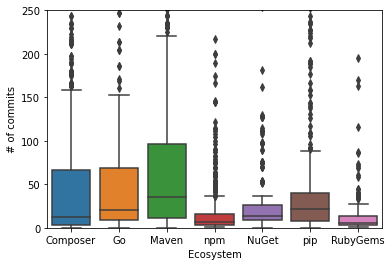

In [114]:
ax = sns.boxplot(y='commit_count', x='ecosystem', data = df, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems'])
ax.set(ylim=(0,250), xlabel='Ecosystem', ylabel='# of commits')
plt.savefig('commit_complexity.png',bbox_inches='tight')

In [115]:
q = '''select id as advisory_id, severity
    from advisory'''
sev = pd.DataFrame(sql.execute(q))
sev

,advisory_id,severity
0,npm:abaaso:20180220,L
1,npm:actionhero:20121127,M
2,npm:actionhero:20161027,M
3,npm:address-rfc2822:20180225,H
4,npm:adm-zip:20180415,H
...,...,...
6951,SNYK-RUBY-WRITTEN-548685,M
6952,SNYK-RUBY-YARD-20430,L
6953,SNYK-RUBY-YARD-455636,H
6954,SNYK-RUBY-ZIPRUBY-20431,H


In [116]:
q = '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id, 
       ifnull(sum(lines_added + lines_removed),0) as loc_change
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    left join (select scf.* from change_file scf
    join file_extensions fe on scf.format = fe.id
    where filename in ('package.json','package-lock.json','yarn.lock')) as cf on ri.id = cf.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    and p.ecosystem = 'npm'
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
dep_cf = pd.DataFrame(sql.execute(q))
dep_cf

,advisory_id,ecosystem,package_id,release_id,loc_change
0,SNYK-JS-ABSOLUNETKAFE-1017403,npm,356,1,2
1,SNYK-JS-APOLLOGATEWAY-174915,npm,1852,4,0
2,SNYK-JS-AWSSDKSHAREDINIFILELOADER-1049304,npm,3892,5,223
3,SNYK-JS-BERSLUCASLILJS-450217,npm,1793,6,0
4,SNYK-JS-CKEDITORCKEDITOR5LINK-72892,npm,1628,7,18
...,...,...,...,...,...
726,SNYK-JS-YARN-451571,npm,3598,852,2
727,SNYK-JS-YARN-548869,npm,3598,853,4
728,SNYK-JS-ZENNCLI-1024443,npm,258,855,0
729,npm:zeroclipboard:20120528,npm,2842,856,2


In [117]:
dep_cf['loc_change'].median()

4.0

In [118]:
q = '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id, 
       ifnull(sum(lines_added + lines_removed),0) as loc_change
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    left join (select scf.* from change_file scf
    join file_extensions fe on scf.format = fe.id
    where filename in ({})) as cf on ri.id = cf.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    and p.ecosystem = %s
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
hm = {
    'npm': ['package.json','package-lock.json','yarn.lock'],
    'Maven':['pom.xml'],
    'RubyGems': ['Gemfile','Gemfile.lock'],
    'Composer':['composer.json','composer.lock'],
    'Go':['go.mod','Gopkg.toml','Gopkg.lock','vendor/vendor.json'],
    'pip':['requirements.txt','pipfile','pipfile.lock','setup.py'],
    'NuGet':['packages.config','.nuspec']
}
for k in hm.keys():
    query = q.format(','.join(['%s']*len(hm[k])))
    dep_cf = pd.DataFrame(sql.execute(query, tuple(hm[k]+[k])))
    print(k, dep_cf['loc_change'].median())


npm 4.0
Maven 4.0
RubyGems 0.0
Composer 0.0
Go 0.0
pip 0.0
NuGet 0.0


In [119]:
q='''select id as advisory_id,
       case
        when id in (select advisory_id from advisoryCVE) then 'cve'
        else 'noncve'
end as ifcve
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))
df = pd.merge(df, ifcve, on='advisory_id')

In [120]:
from scipy.stats import mannwhitneyu

In [121]:
cve = df[df['ifcve'] == 'cve']
noncve = df[df['ifcve'] == 'noncve']
cve['commit_count'].median(), noncve['commit_count'].median(), cve['loc_change'].median(), noncve['loc_change'].median()

(16.0, 11.0, 571.0, 442.0)

In [122]:

mannwhitneyu(cve['commit_count'], noncve['commit_count']), mannwhitneyu(cve['loc_change'], noncve['loc_change'])

(MannwhitneyuResult(statistic=1794260.5, pvalue=0.00878435629093473),
 MannwhitneyuResult(statistic=1842967.0, pvalue=0.1332158942224153))

In [123]:
q='''select id as advisory_id, severity
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))
df = pd.merge(df, ifcve, on='advisory_id')
df

,advisory_id,ecosystem,package_id,release_id,commit_count,file_count,loc_change,contributor_count,ifcve,severity
0,npm:actionhero:20161027,npm,3419,42,9,7,59,2,noncve,M
1,npm:adm-zip:20180415,npm,2289,45,3,5,83,1,cve,H
2,npm:aerospike:20161101,npm,2956,48,8,9,235,1,cve,H
3,npm:ag-grid:20160519,npm,3410,49,46,270,10450,2,noncve,M
4,npm:angular-gettext:20140624,npm,3384,64,1,0,0,1,noncve,M
...,...,...,...,...,...,...,...,...,...,...
4734,SNYK-RUBY-WEBRICK-1013845,RubyGems,438,5474,2,2,8,2,cve,H
4735,SNYK-RUBY-WEBRICK-1013845,RubyGems,438,5475,2,2,8,2,cve,H
4736,SNYK-RUBY-WEBSOCKETEXTENSIONS-570830,RubyGems,843,5492,6,4,64,1,cve,H
4737,SNYK-RUBY-YARD-20430,RubyGems,1699,5548,5,5,126,3,noncve,L


In [124]:
l, m, h = df[df['severity']=='L'],df[df['severity']=='M'],df[df['severity']=='H']
l['commit_count'].median(), m['commit_count'].median(), h['commit_count'].median()

(25.0, 16.0, 12.0)

In [125]:
mannwhitneyu(l['commit_count'], m['commit_count']), mannwhitneyu(m['commit_count'],h['commit_count']), mannwhitneyu(l['commit_count'], h['commit_count'])

(MannwhitneyuResult(statistic=235169.0, pvalue=0.004831088478413452),
 MannwhitneyuResult(statistic=2303131.0, pvalue=2.1624804717294466e-08),
 MannwhitneyuResult(statistic=179421.5, pvalue=1.3241565896250198e-07))

In [126]:
l['loc_change'].median(), m['loc_change'].median(), h['loc_change'].median()

(946.0, 549.0, 506.5)

In [127]:
mannwhitneyu(['loc_change'],m['loc_change']), mannwhitneyu(m['loc_change'], h['loc_change']), mannwhitneyu(l['loc_change'], h['loc_change'])

(MannwhitneyuResult(statistic=0.0, pvalue=0.04175710806214299),
 MannwhitneyuResult(statistic=2446829.0, pvalue=0.014207553567278831),
 MannwhitneyuResult(statistic=198731.0, pvalue=0.0010236426885019264))

In [128]:
len(noncve)

1012

In [158]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date,release_id,
        earliest_fix_commit_date, latest_fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release,
       concat(advisory_id, package_id, version) as total_release
        from
        (select advisory_id, min(commit_date) as earliest_fix_commit_date, max(commit_date) as latest_fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date, ri.id as release_id
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;'''
frd = pd.DataFrame(sql.execute(q))
def get_fix_commit_date(row):
    if row['earliest_fix_commit_date'] == row['latest_fix_commit_date']:
        return row['earliest_fix_commit_date']
    else:
        if row['latest_fix_commit_date'] <= row['release_date']:
            return row['latest_fix_commit_date']
        else:
            return row['earliest_fix_commit_date']

frd['fix_commit_date'] = frd.apply(get_fix_commit_date, axis=1)
frd['fix_to_release_delay'] = (frd['release_date'] - frd['fix_commit_date']).dt.total_seconds()
frd['fix_to_release_delay'] = round ( frd['fix_to_release_delay'] / (3600 * 24))
frd['disclose_to_fix_delay'] = (frd['fix_commit_date'].dt.date - frd['disclose_date']).dt.days
frd['release_to_publish_delay'] = (frd['publish_date'] - frd['release_date'].dt.date).dt.days
frd['fix_to_publish_delay'] = (frd['publish_date'] - frd['fix_commit_date'].dt.date).dt.days

In [163]:
frd = frd[['advisory_id','release_id','fix_to_release_delay']]
temp = pd.merge(df, frd, on=['advisory_id', 'release_id'])

In [164]:
len(df), len(frd), len(temp)

(4739, 2789, 2375)

In [166]:
temp = temp[temp['fix_to_release_delay']==0]

In [182]:
temp['commit_count'].median(), temp['loc_change'].median(), temp['file_count'].median(), temp['contributor_count'].median()

(7.0, 160.0, 7.0, 2.0)

In [180]:
temp = temp.sample(frac=1).reset_index(drop=True)
temp.to_csv('secrel_with_zero_delay.csv', index=False, header=True)